## NOTE: SOME CODE AS BEEN BORROWED FROM AARON'S OH OR GITHUB

### IMPORTS

In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm.auto import tqdm
import pytensor.tensor as pt
import sympy
import sympy as smp
import scipy.optimize as spo

### QUESTION 1

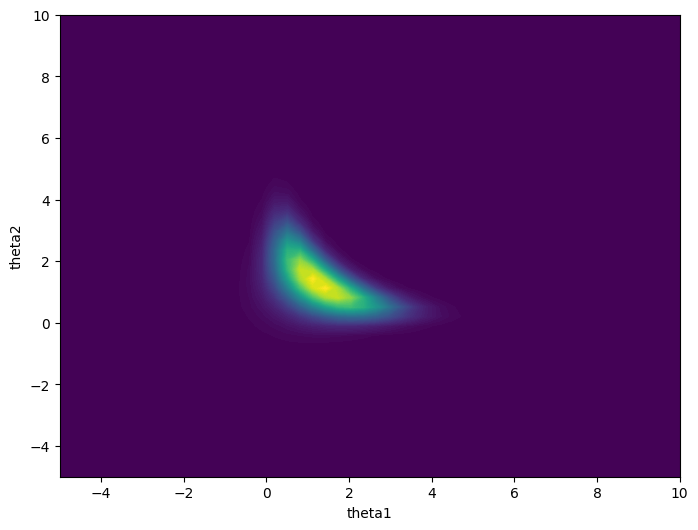

In [34]:
# THETAS
theta1, theta2 = np.linspace(start=-5, stop=10), np.linspace(start=-5, stop=10)
theta1_grid, theta2_grid = np.meshgrid(theta1, theta2)

# POSTERIOR
def unnorm_pdf(theta1, theta2):
    eq_exp = (-1/2) * ((theta1**2 * theta2**2) + (theta1**2) + (theta2**2) - (2 * theta1 * theta2) - (4 * theta1) - (4 * theta2))
    return np.exp(eq_exp)

p_thetaGivenY = unnorm_pdf(theta1_grid, theta2_grid)

# TWO-DIMENSIONAL PLOT
plt.figure(figsize=(8, 6))
plt.contourf(theta1_grid, theta2_grid, p_thetaGivenY, levels=100)
plt.xlabel("theta1")
plt.ylabel("theta2")
plt.show()

$$
\text{PART 1}
$$

In [ ]:
rng = np.random.default_rng(1)

n = 10000
burn = 1000
samples = n + burn

theta1_mcmc = np.zeros(samples)
theta2_mcmc = np.zeros(samples)

rho = 0.4
unif_dist = rng.uniform(0, 1, size=samples)

# ACCEPT_RATIO NEEDS TO BE UPDATED FOR THIS CASE
def accept_ratio(rho1, rho2):

    pdf = unnorm_pdf(theta1_grid, theta2_grid)
    proposal1 = 1 / (1 - rho1**2)**(3/2)
    proposal2 = 1 / (1 - rho2**2)**(3/2)

    # RETURN STATEMENT NEEDS TO BE FIXED
    return  (pdf / pdf) * (proposal1 / proposal2)

for i in tqdm(range(n)):
    rho_prop = rng.uniform(-1, 1)
    acceptance_ratio = accept_ratio(rho_prop) /  accept_ratio(rho)
    decision = min(acceptance_ratio, 1)
    if unif_dist[i] < decision:
        rho = rho_prop
        theta1_mcmc[i] = theta1
        theta2_mcmc[i] = theta2

theta1_burn = theta1_mcmc[burn:]
theta2_burn = theta2_mcmc[burn:]

$$
\text{PART 2}
$$

In [ ]:
# WOULD BE RUN AFTER PART 1 COMPLETE
samples = np.column_stack((theta1_burn, theta2_burn))

plt.figure(figsize=(8, 6))
plt.contourf(theta1_grid, theta2_grid, p_thetaGivenY, levels=50, cmap="viridis")
plt.scatter(samples[:, 0], samples[:, 1], color="red", s=0.005, label="Samples")
plt.xlabel("theta1")
plt.ylabel("theta2")
plt.title("Samples on the 2D Unnormalized Posterior")
plt.show()

$$
\text{PART 3}
$$

In [ ]:
# NEEDS TO BE UPDATED FOR THIS CASE
# WOULD BE RUN AFTER PART 1 COMPLETE

# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 10))

# # Scatterplot
# ax1.grid(True)
# ax1.scatter(lambdas, mus)
# ax1.set_xlabel("lambda vs mu")

# # Histogram 1
# ax2.grid(True)
# ax2.hist(mus, color="lightgreen", density=True, bins=50)
# ax2.set_xlabel("mu")

# # Histogram 2
# ax3.grid(True)
# ax3.hist(lambdas, color="lightblue", density=True, bins=50)
# ax3.set_xlabel("lambda")

# plt.show()

$$
\text{PART 4}
$$

In [35]:
# EQUITAILED CREDIBLE SETS
# WOULD BE RUN AFTER PART 1 COMPLETE
mean1, std1, mean2, std2 = np.mean(theta1_mcmc), np.std(theta1_mcmc), np.mean(theta2_mcmc), np.std(theta2_mcmc)

lower_eqt1 = stats.norm.ppf(0.025, loc=mean1, scale=std1)
upper_eqt1 = stats.norm.ppf(0.975, loc=mean1, scale=std1)
lower_eqt2 = stats.norm.ppf(0.025, loc=mean2, scale=std2)
upper_eqt2 = stats.norm.ppf(0.975, loc=mean2, scale=std2)
print(f"Equitailed Credible Sets:\nTheta1:\n[{lower_eqt1} {upper_eqt1}]\nTheta2:\n[{lower_eqt2} {upper_eqt2}]")

Equitailed Credible Sets:
Theta1:
[-6.158362711426898 11.158362711426896]
Theta2:
[-6.158362711426898 11.158362711426896]


### QUESTION 2

In [ ]:
problem2 = pd.read_csv('problem2.csv')

In [ ]:
problem2.head()

,x1,x2,y
0,0.77,0.19,10.84
1,0.10,0.45,8.75
2,0.58,0.64,9.93
3,0.76,0.76,10.90
4,0.84,0.49,10.45


In [ ]:
with pm.Model() as p2:

    # DATA
    x_i1 = pm.Data(name="x_i1",
                   value=problem2['x1'],
                   mutable=False)
    x_i2 = pm.Data(name="x_i2",
                   value=problem2['x2'],
                   mutable=False)

    y = pm.Data(name="y",
                value=problem2['y'],
                mutable=False)

    # NONINFORMATIVE PRIORS
    beta0 = pm.Normal(name="beta0",
                      mu=0,
                      tau=0.0001)
    beta1 = pm.Normal(name="beta1",
                      mu=0,
                      tau=0.0001)
    beta2 = pm.Normal(name="beta2",
                      mu=0,
                      tau=0.0001)
    alpha0 = pm.Normal(name="alpha0",
                      mu=0,
                      tau=0.0001)
    alpha1 = pm.Normal(name="alpha1",
                      mu=0,
                      tau=0.0001)
    alpha2 = pm.Normal(name="alpha2",
                      mu=0,
                      tau=0.0001)

    # GETTING EPSILON
    sigma2 = pm.math.exp(alpha0 + (alpha1 * x_i1) + (alpha2 * x_i2))
    sigma_sq = pm.Deterministic(name='sigma squared', var=sigma2)
    epsilon_i = pm.Normal(name='epsilon_i',
                          mu=0,
                          sigma=sigma_sq)

    # GETTING PREDICTED Y
    mu = pm.Deterministic(name='mu', var=beta0 + (beta1 * x_i1) + (beta2 * x_i2) + epsilon_i)
    y_i = pm.Normal(name='y_i',
                    mu=mu,
                    tau=0.0001,
                    observed=y)

    trace_p2 = pm.sample(draws=10000,
                         tune=1000,
                         cores=None,
                         chains=2)

$$
\text{PART 1}
$$

In [ ]:
az.summary(trace_p2, hdi_prob=0.95, var_names=['beta0', 'beta1', 'beta2', 'alpha0', 'alpha1', 'alpha2'], kind='stats')

,mean,sd,hdi_2.5%,hdi_97.5%
beta0,8.204,6.889,-4.261,20.586
beta1,5.263,9.495,-13.325,22.129
beta2,-1.373,7.758,-18.619,13.373
alpha0,1.623,2.269,-2.191,3.615
alpha1,-2.979,1.261,-4.780,-0.173
alpha2,-1.463,2.386,-3.928,2.993


$$
\text{PART 2}
$$

In [ ]:
mean_variance = az.summary(trace_p2, hdi_prob=0.95, var_names=['mu', 'sigma squared'], kind='stats')

In [ ]:
mean_variance['hdi_2.5%'].min(), mean_variance['hdi_2.5%'].max(), mean_variance['hdi_97.5%'].min(), mean_variance['hdi_97.5%'].max()

(-33.052, 4.766, 0.873, 58.439)

In [ ]:
stat_sig = mean_variance[(mean_variance['hdi_2.5%'] < 0) & (mean_variance['hdi_97.5%'] > 0)]
not_stat_sig = mean_variance[(mean_variance['hdi_2.5%'] > 0) | (mean_variance['hdi_97.5%'] < 0)]

$$
\text{These mean and variance variables are statistically signficant}
$$

In [ ]:
# MEAN AND VARIANCE VARIABLES ARE STATISTICALLY SIGNIFICANT
stat_sig

,mean,sd,hdi_2.5%,hdi_97.5%
mu[1],9.858,5.716,-0.948,19.677
mu[5],11.952,9.351,-3.162,29.976
mu[7],8.765,5.108,-0.142,18.888
mu[14],11.587,6.046,-0.442,23.802
mu[15],8.664,5.542,-0.958,19.631
...,...,...,...,...
mu[985],8.174,7.140,-4.693,20.552
mu[986],7.103,7.004,-4.606,20.949
mu[988],8.277,5.379,-0.986,19.494
mu[998],14.045,9.897,-5.080,33.864


$$
\text{These mean and variance variables are not statistically signficant}
$$

In [ ]:
# MEAN AND VARIANCE VARIABLES ARE NOT STATISTICALLY SIGNIFICANT
not_stat_sig

,mean,sd,hdi_2.5%,hdi_97.5%
mu[0],12.287,4.915,3.422,23.637
mu[2],10.344,3.740,3.359,17.622
mu[3],11.154,4.767,2.216,21.026
mu[4],12.017,4.734,2.681,21.151
mu[6],9.899,4.916,0.153,19.341
...,...,...,...,...
sigma squared[995],0.371,0.476,0.089,1.422
sigma squared[996],0.499,0.665,0.117,1.978
sigma squared[997],1.403,0.982,0.163,3.483
sigma squared[998],7.328,5.598,0.055,13.572


$$
\text{PART 3}
$$

In [ ]:
x1 = problem2['x1']
x2 = problem2['x2']

def mini(x, alpha0, alpha1, alpha2):
    return alpha0 + (x[0] * alpha1) + (x[1] * alpha2)

alpha0 = trace_p2.posterior["alpha0"].mean(dim=["chain", "draw"]).to_numpy()
alpha1 = trace_p2.posterior["alpha1"].mean(dim=["chain", "draw"]).to_numpy()
alpha2 = trace_p2.posterior["alpha2"].mean(dim=["chain", "draw"]).to_numpy()

x_init = [0, 0]

bounds = [(x1.min(), x2.max()), (x2.min(), x2.max())]

result = spo.minimize(mini, x_init, args=(alpha0, alpha1, alpha2), bounds=bounds)

final_x1, final__x2 = result.x

print(f"Optimal Values:\nx1: {final_x1}\nx2: {final__x2}")

Optimal Values:
x1: 1.0
x2: 1.0


### QUESTION 3

In [ ]:
problem3 = pd.read_csv('problem3.csv')

In [ ]:
problem3.head()

,x,y
0,0.988,0
1,0.222,1
2,0.285,3
3,0.326,3
4,0.140,2


In [ ]:
# FOR PART 2
beta0, beta1, beta2 = smp.symbols("beta0 beta1 beta2", real=True)
x = smp.symbols("x", real=True)

func_min = (beta0 + beta1 * x + beta2 * x**2)

derivative = smp.diff(func_min, x)

smp.solve(derivative, x)

[-beta1/(2*beta2)]

In [ ]:
with pm.Model() as p3:

    x = pm.Data(name="x",
                value=problem3["x"],
                mutable=False)

    y = pm.Data(name="y",
                value=problem3["y"],
                mutable=False)

    beta0 = pm.Normal(name="beta0",
                      mu=0,
                      tau=0.0001)
    beta1 = pm.Normal(name='beta1',
                      mu=0,
                      tau=0.0001)
    beta2 = pm.Normal(name='beta2',
                      mu=0,
                      tau=0.0001)

    regression = beta0 + pm.math.dot(l=x, r=beta1) + pm.math.dot(l=x**2, r=beta2)
    lambda_xi = pm.math.exp(regression)

    pm.Deterministic(name="concentration_min", var=-beta1 / (2 * beta2))

    y_i = pm.Poisson('y_i',
                     mu=lambda_xi,
                     observed=y)

    trace_p3 = pm.sample(draws=10000,
                         tune=1000,
                         cores=None,
                         chains=2)

$$
\text{PART 1}
$$

In [ ]:
az.summary(trace_p3, hdi_prob=0.95, var_names=['beta0', 'beta1', 'beta2'], kind='stats')

,mean,sd,hdi_2.5%,hdi_97.5%
beta0,1.319,0.130,1.061,1.568
beta1,-4.158,0.726,-5.564,-2.728
beta2,3.150,0.751,1.705,4.632


$$
\text{PART 2}
$$

In [ ]:
az.summary(trace_p3, hdi_prob=0.95, var_names=['concentration_min'], kind='stats')

,mean,sd,hdi_2.5%,hdi_97.5%
concentration_min,0.675,0.094,0.566,0.813


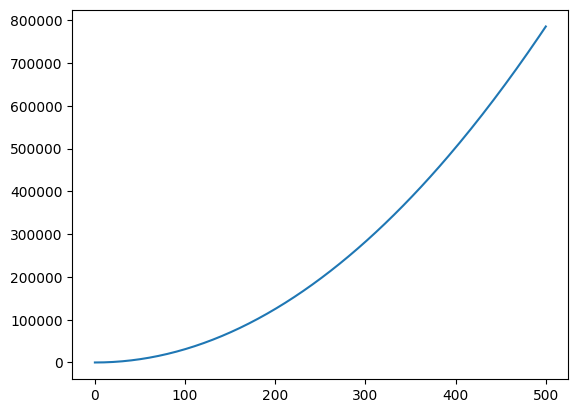

In [ ]:
# PROOF THAT ABOVE IS THE MIN
beta0 = trace_p3.posterior["beta0"].mean(dim=["chain", "draw"]).to_numpy()
beta1 = trace_p3.posterior["beta1"].mean(dim=["chain", "draw"]).to_numpy()
beta2 = trace_p3.posterior["beta2"].mean(dim=["chain", "draw"]).to_numpy()
xx = np.linspace(0, 500, 200)
y_model = beta0 +beta1 * xx + beta2 * np.power(xx, 2)

plt.plot(xx, y_model)